# Tuning the kinetic parameters for asphaltene precipitation and aggregation

This code calculates kp and kag coefficients to fit the differential equation system to experimental data. From the best calculated kp and kag, a0, a1 and c0 coefficients are calculated. These coefficients depend on Temperature and viscosity.

In the case of a Python script file (`*.py`), I will write a [module-level docstring][mod_docstring] (because you can't write markdown in a Python script).

<!--refs-->
[mod_docstring]: https://realpython.com/documenting-python-code/

In [28]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [29]:
# define utility functions
def unitConvert_T(val, unit_in: str, unit_out: str) -> float:
    '''unit converter for temperature'''
    if unit_in.upper() == 'F' and unit_out.upper() == 'K':
        return (val - 32) * 5/9 + 273.15
    elif unit_in.upper() == 'C' and unit_out.upper() == 'K':
        return val + 273.15
    elif unit_in.upper() == 'F' and unit_out.upper() == 'C':
        return (val - 32) * 5/9

:memo: CJS note: I recommend using a `data` folder to store raw data and accessing the folder using a relative file path. We use relative file paths because the location of the data file is different on our different computers, but if the project root folders are the same, then relative file paths will work on our different computers.

There is also a Python library called [`pathlib`][pathlib] that helps to construct cross-platform (Windows, Mac, Linux) file paths. We don't need this feature now as we all use Windows, but it is good to know of the existence of this package in case we ever need it. 

<!--refs-->
[pathlib]: https://www.freecodecamp.org/news/how-to-use-pathlib-module-in-python/

In [30]:
# read aggregation test info data
file_name = './data/Ag_kinetics.xlsx'
df = pd.read_excel(file_name, sheet_name='Info', header=7, usecols='b:q')
df = df[df['sheet'].notna()]
display(df)

,Set,sheet,T (F),P (bar),Base,Solvent,S Amt (vol%),Precip,P Amt (vol%),Ceq (wtf Asp L1/T),visco_L1 (cP),dens_L1 (g/cc),SP_L1 (MPa^0.5),dens_Asp (g/cc),SP_Asp (MPa^0.5),Ca0 (kg/m3)
0,1,Set1,104.0,1.0,STL,Tol,75.0,C6,55.0,0.858282,0.485850,0.748791,15.670999,NaN,22.889265,14.752502
1,2,Set2,104.0,1.0,STL,Tol,75.0,C7,60.0,0.833403,0.537347,0.762251,15.816842,NaN,22.889265,13.570000
2,3,Set3,104.0,1.0,STL,Tol,75.0,C8,60.0,0.848633,0.614240,0.777780,15.970580,NaN,22.889265,13.846450
3,4,Set4,176.0,1.0,STL,Tol,75.0,C6,62.0,0.837227,0.362247,0.732269,15.038418,NaN,22.349547,12.466965
4,5,Set5,176.0,1.0,STL,Tol,75.0,C7,62.0,0.853216,0.419526,0.749536,15.227162,NaN,22.349547,12.760944
5,6,Set6,176.0,1.0,STL,Tol,75.0,C8,62.0,0.858430,0.550031,0.780260,15.563012,NaN,22.349547,13.284011


In [31]:
# pass raw data to numpy arrays
info = df.to_numpy()
sheet_names = info[:,1]
T_set = unitConvert_T(info[:,2], "F", "K")
Ceq_set = info[:,9]
mu_set = info[:,10]
ca0_set = info[:,15]

:memo: CJS note: by convention, `df` denotes a Pandas Dataframe variable. 

If you do a `.to_list()` or .`to_numpy()` conversion, then avoid using names like `df` for the return as these functions return a `list` and `ndarray`, respectively.

```Python
df = df.to_numpy()  # NOT recommended (because return from `.to_numpy()` method is NOT a Dataframe)
xy = df.to_numpy()  # recommended
```

In [32]:
t_exp = []
c_exp = []

# loop over the sheet names and store time and experimental data
# into t_exp and c_exp
for sheet_name in sheet_names:
    # read the relevant columns from the sheet into a DataFrame
    df_AgData = pd.read_excel(file_name, sheet_name=sheet_name, usecols='b:c')
    data = df_AgData.to_numpy()

    #these variables contain many arrays with time and experimental data
    #each dataset can be accessed with t_exp[index]
    t_exp.append(data[:,0])
    c_exp.append(data[:,1])

In [33]:
# define functions
def fun_C_dt(t, y, kP, kAg) -> tuple[float]:
    '''
    arguments
    ---------
    t : float
        time [min]
    y : tuple(array[float])
        Cf : array[float]
        Cag : array[float]
        C : array[float]
    kP : float
        precipitation kinetics [1/s]
    kAg : float
        aggregation kinetics [1/s]
    
    return
    ------
    Cf_dt: array[float]
            dissolved asph concentration (Cf) wrt time
    Cag_dt: array[float]
            aggregated asph concentration (Cag) wrt time
    C_dt: array[float]
            primary particles concentration (C) wrt time  
    '''
    Cf, Cag, C = y
    
    Cf_dt = -kP*(Cf - Ceq)
    Cag_dt = kAg*C**2
    C_dt = kP*(Cf - Ceq) - kAg*C**2
    
    return [Cf_dt, Cag_dt, C_dt]

# initial conditions
y0 = [1.0, 0.0, 0.0]

# Define a function that returns the model values for given parameters
def Ag_model(t, kp, kag):
    sol = solve_ivp(fun=lambda t, y: fun_C_dt(t, y, kp, kag), t_span=t_span, y0=y0, t_eval=t)
    return sol.y[0]

Use `curve_fit()` to find the best coefficient values to fit experimental data.

In [34]:
# define initial guesses
p0 = np.array([.001, .001])

# initialize optimal coefficients list
kag_best = []
kp_best = []

# loop thru each set and extract exp data
for i, t_ in enumerate(t_exp):
    c_ = c_exp[i]
    Ceq = Ceq_set[i]
    
    # time span
    t_span = (0.0, t_exp[i][-1])
    
    # find optimal values for kp and kag
    popt, pcov = curve_fit(Ag_model, t_, c_, p0=p0, method='trf')
    kag_best.append(popt[0])
    kp_best.append(popt[1])

# Print the best values
print(f"Best kp: {kp_best}")
print(f"Best kag: {kag_best}")

Best kp: [0.06854795086803672, 0.07833670200168419, 1.6415057617515256, 0.06411700959205485, 0.0551296401984512, 0.02624318642997762]
Best kag: [1.5023457924482249, 1.8666119625777648, 10.31067804976047, 2.222516124915874, 1.2333783445047712, 0.8060832458440117]


R2 Score: 86.6048711802313 %


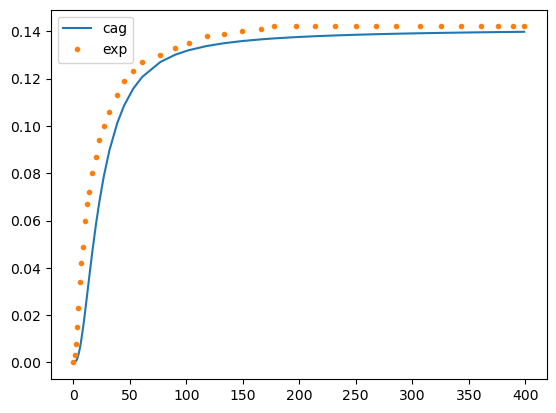

R2 Score: 49.81529382441791 %


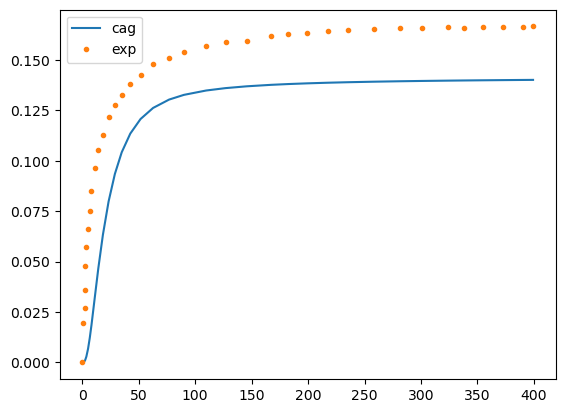

R2 Score: 20.59532653175208 %


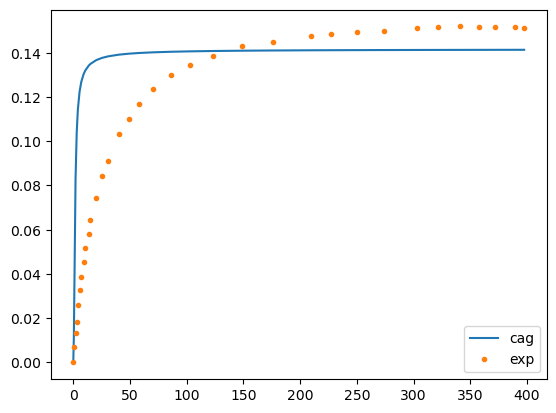

R2 Score: 79.38449445666467 %


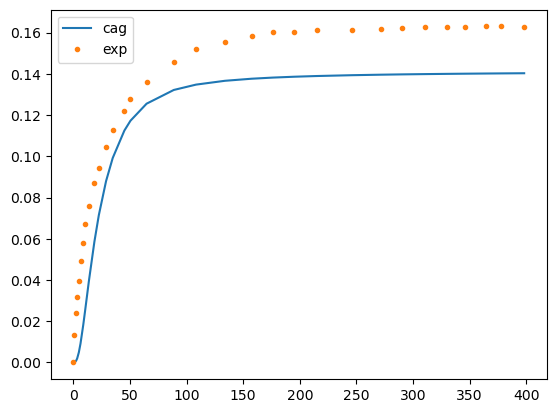

R2 Score: 95.00284821461786 %


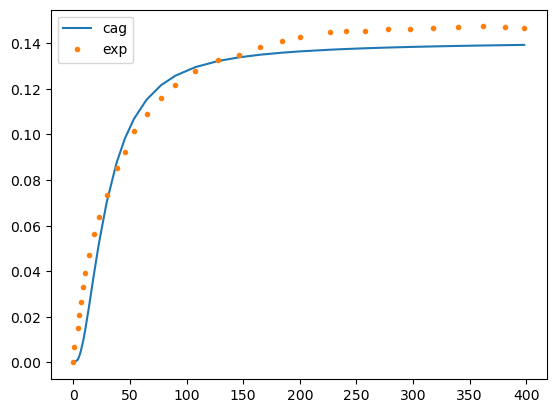

R2 Score: 93.26359646937766 %


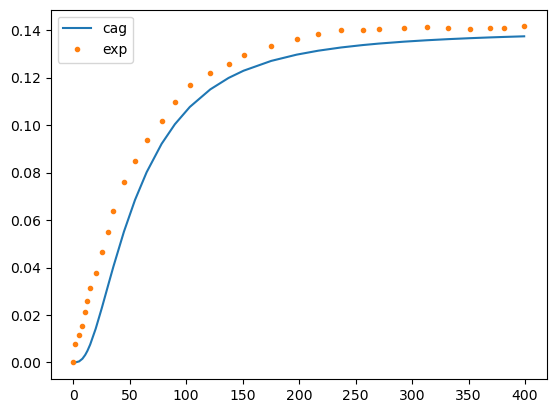

In [35]:
#Plot each function with their corresponding best coefficients
for i, t_ in enumerate(t_exp):
    
    #each set of time and data has different length and time span has to change accordingly
    t_span = (0.0, t_exp[i][-1])
    sol_best = solve_ivp(fun=lambda t, y: fun_C_dt(t, y, kp_best[i], kag_best[i]), t_span=t_span, y0=y0, t_eval=t_exp[i])
    
    #print R2 score to evaluate quality of approximation
    print('R2 Score:',r2_score(c_exp[i],sol_best.y[1])*100,'%')
    plt.plot(sol_best.t, sol_best.y[1], label='cag')
    plt.plot(t_exp[i], c_exp[i], label = 'exp', marker ='.', linestyle='None')
    plt.legend()
    plt.show()

Calculating a0, a1 and c0, from the obtained best kp and kag. The coefficients depend on T and mu.

In [36]:
# Define the functions for kp and kag
def kp(T, a0, a1):
    return a0 / np.exp(a1 / T)

def kag(T, mu, c0):
    R = 8.314 # J/mol.K, gas constant
    return ca0 * ((R * T) / (mu*1000)) * c0

# Define the function to fit
#Temperature and viscosity now influence the model fitting
def fit_func(data, a0, a1, c0):
    T, mu = data
    return np.hstack((kp(T, a0, a1), kag(T, mu, c0))).astype(float)

#define temperature and viscosity of each set of data
T = np.array(T_set)
mu = np.array(mu_set)
ca0 = np.array(ca0_set)

# Define the data as a tuple
data = (T, mu)

# Perform the fit
p0 = np.array([1, .5, .5]) # initial guesses for a0, a1, and c0
popt, pcov = curve_fit(fit_func, data, np.concatenate((kp_best, kag_best)))

# Extract parameters
a0, a1, c0 = popt

# Print the results
print(f"a0 = {a0:.4f}")
print(f"a1 = {a1:.4f}")
print(f"c0 = {c0:.4f}")

a0 = 0.0000
a1 = -6880.2523
c0 = 0.0333


Using these coefficients solve the differential equations to obtain a new approximation

In [37]:
# define the differential equation system with all three coefficients and viscosity and temperature data
def derivatives_a0a1c0(t, y, a0, a1, c0, mu, Ceq, T, Ca0):
    R = 8.314
    cf, cag, c = y
    
    Cf_dt = -(a0/np.exp(a1/T))*(cf - Ceq)
    Cag_dt = (Ca0*((1/750*1/3))*((R*T)/mu)*c0)*c**2
    C_dt = (a0/np.exp(a1/T))*(cf - Ceq) - (Ca0*((1/750*1/3))*((R*T)/mu)*c0)*c**2
    
    return [Cf_dt, Cag_dt, C_dt]

# time span, calculate for each data set
t_span = (0.0, t_exp[-1])

# initial conditions
y0 = [1.0, 0.0, 0.0]

# Define a function that returns the model values for given parameters
def model(t, a0, a1, c0):
    sol = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0, mu, Ceq, T, ca0), t_span=t_span, y0=y0, t_eval=t_exp)
    return sol.y[0]

Plot the new function given by coefficients a0, a1 and c0

R2 Score: 95.86364643725105 %


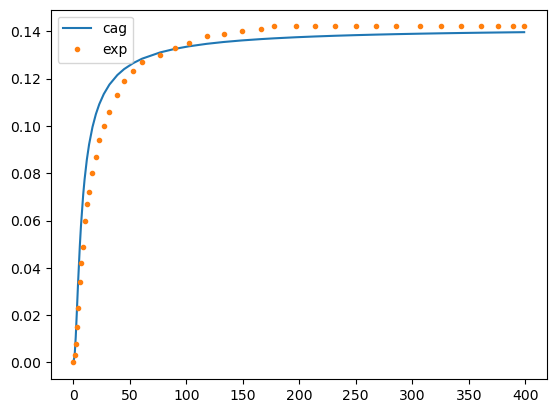

R2 Score: 96.78915803943066 %


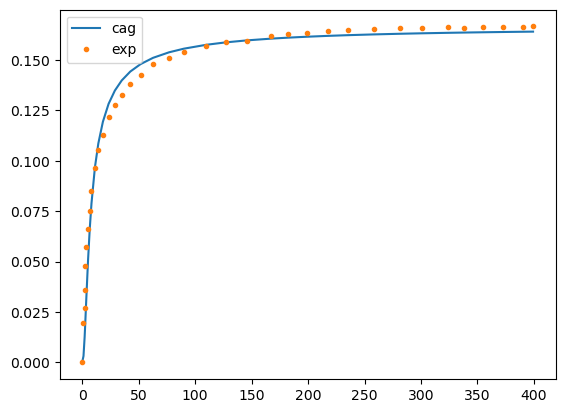

R2 Score: 91.71061499033655 %


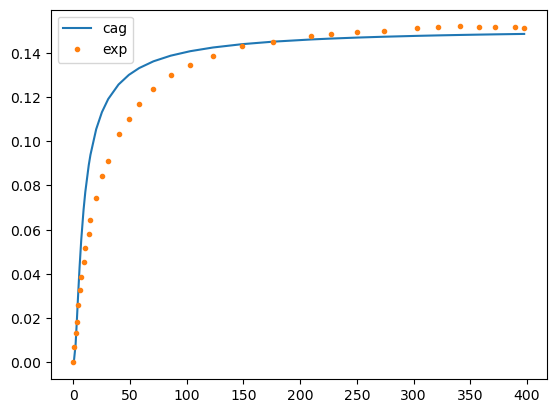

R2 Score: 83.11658841675185 %


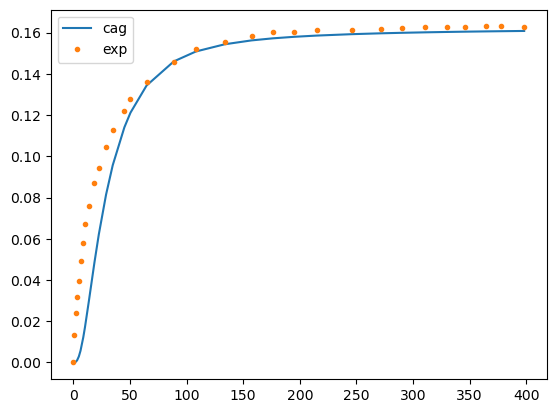

R2 Score: 95.28241205750827 %


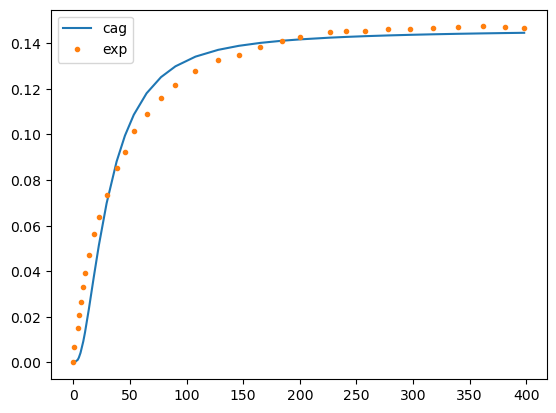

R2 Score: 97.34308384854916 %


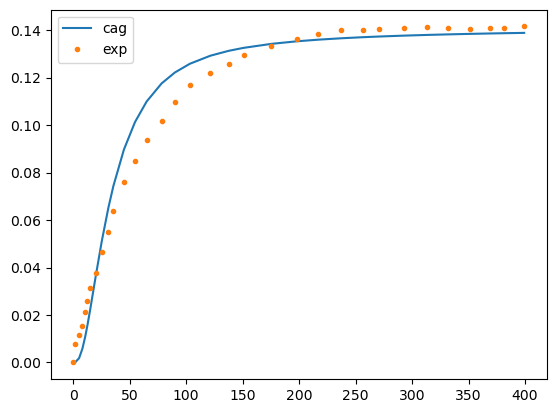

In [38]:
for i in range(len(t_exp)):
    mu = mu_set[i]
    Ceq = Ceq_set[i]
    T = T_set[i]
    ca0 = ca0_set[i]

    t_span = (0.0, t_exp[i][-1])
    sol_best = solve_ivp(fun=lambda t, y: derivatives_a0a1c0(t, y, a0, a1, c0, mu, Ceq, T, ca0), t_span=t_span, y0=y0, t_eval=t_exp[i])
    
    print('R2 Score:',r2_score(c_exp[i],sol_best.y[1])*100,'%')
    plt.plot(sol_best.t, sol_best.y[1], label='cag')
    plt.plot(t_exp[i], c_exp[i], label = 'exp', marker ='.', linestyle='None')
    plt.legend()
    plt.show()